In [1]:
!pip install networkx matplotlib

In [2]:
import random
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import networkx as nx

In [3]:
# Bin dimensions
BIN_WIDTH = 80
BIN_HEIGHT = 40

# Number of rectangles
NUM_RECTANGLES = 8

# Rectangle dimensions (randomly generated)
rectangles = [(random.randint(5, 20), random.randint(5, 20)) for _ in range(NUM_RECTANGLES)]

# Print rectangle dimensions
print("Rectangle dimensions (width, height):", rectangles)

Rectangle dimensions (width, height): [(18, 20), (18, 19), (15, 18), (6, 7), (13, 10), (10, 19), (8, 11), (17, 11)]


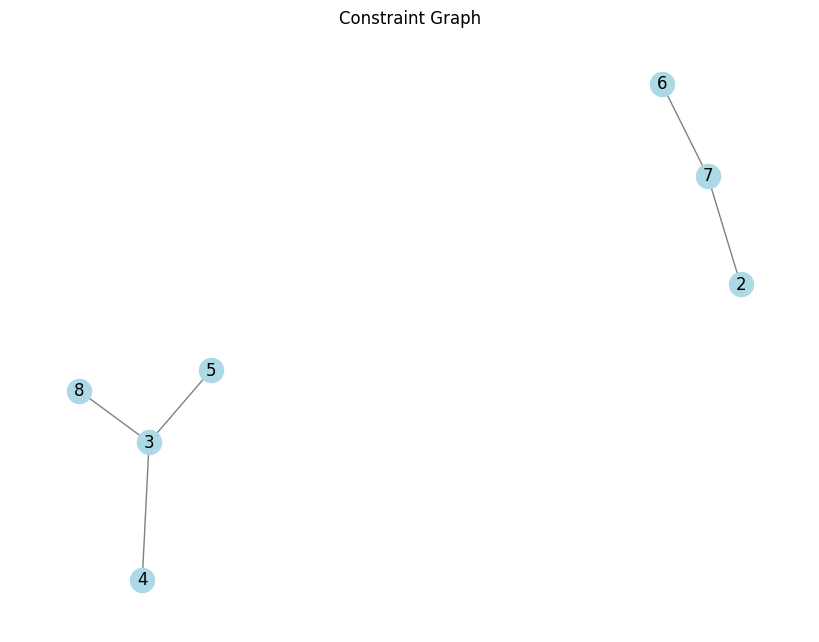

In [4]:
# Define constraint graph
constraint_graph = nx.Graph()
constraint_graph.add_edges_from([(3, 4), (3, 5), (3, 8), (7, 6), (7, 2)])  # Rectangle numbering starts at 1

# Plot the constraint graph
plt.figure(figsize=(8, 6))
nx.draw(constraint_graph, with_labels=True, node_color='lightblue', edge_color='gray')
plt.title('Constraint Graph')
plt.show()

In [5]:
# Constraints handling
def is_valid_placement(rectangles_placement):
    for i, (x1, y1, w1, h1) in enumerate(rectangles_placement):
        # Check if rectangle is within bin boundaries
        if x1 < 0 or y1 < 0 or x1 + w1 > BIN_WIDTH or y1 + h1 > BIN_HEIGHT:
            return False
        # Check separation and overlap with other rectangles
        for j, (x2, y2, w2, h2) in enumerate(rectangles_placement):
            if i != j:
                if not (x1 + w1 + 1 <= x2 or x2 + w2 + 1 <= x1 or y1 + h1 + 1 <= y2 or y2 + h2 + 1 <= y1):
                    return False
    return True

In [6]:
# Distance penalty for constraint violations
def distance_penalty(rectangles_placement, constraint_graph):
    penalty = 0
    for rect_id in constraint_graph.nodes:
        rect_index = rect_id - 1  # Rectangle numbering starts at 1
        rect_x, rect_y, rect_w, rect_h = rectangles_placement[rect_index]
        rect_center = (rect_x + rect_w / 2, rect_y + rect_h / 2)
        for neighbor in constraint_graph.neighbors(rect_id):
            neighbor_index = neighbor - 1
            neighbor_x, neighbor_y, neighbor_w, neighbor_h = rectangles_placement[neighbor_index]
            neighbor_center = (neighbor_x + neighbor_w / 2, neighbor_y + neighbor_h / 2)
            distance = np.sqrt((rect_center[0] - neighbor_center[0])**2 + (rect_center[1] - neighbor_center[1])**2)
            if distance > 10:  # Threshold for 'close'
                penalty += distance - 10  # Penalty is the excess distance
    return penalty

In [7]:
# Objective function (minimize unused area + penalty)
def objective_function(rectangles_placement):
    total_area = BIN_WIDTH * BIN_HEIGHT
    used_area = sum(w * h for (_, _, w, h) in rectangles_placement)
    unused_area = total_area - used_area
    penalty = distance_penalty(rectangles_placement, constraint_graph)
    return unused_area + penalty

In [8]:
# Genetic Algorithm
def genetic_algorithm(population_size, generations):
    population = []
    while len(population) < population_size:
        placement = []
        for i, (w, h) in enumerate(rectangles):
            if i == 0:  # Rectangle 1 (top side)
                x = random.randint(0, BIN_WIDTH - w)
                y = BIN_HEIGHT - h
            elif i == 1:  # Rectangle 2 (bottom side)
                x = random.randint(0, BIN_WIDTH - w)
                y = 0
            else:
                x = random.randint(0, BIN_WIDTH - w)
                y = random.randint(0, BIN_HEIGHT - h)
            placement.append((x, y, w, h))
        if is_valid_placement(placement):
            population.append(placement)

    best_fitness_per_generation = []

    for generation in range(generations):
        population = sorted(population, key=lambda x: objective_function(x))
        best_fitness_per_generation.append(objective_function(population[0]))
        new_population = [population[0]]  # Keep the best solution
        while len(new_population) < population_size:
            parent1, parent2 = random.choices(population[:10], k=2)
            child = []
            for i in range(NUM_RECTANGLES):
                if random.random() < 0.5:
                    child.append(parent1[i])
                else:
                    child.append(parent2[i])
            # Mutation
            if random.random() < 0.1:
                idx = random.randint(0, NUM_RECTANGLES - 1)
                if idx == 0:
                    x = random.randint(0, BIN_WIDTH - rectangles[idx][0])
                    y = BIN_HEIGHT - rectangles[idx][1]
                elif idx == 1:
                    x = random.randint(0, BIN_WIDTH - rectangles[idx][0])
                    y = 0
                else:
                    x = random.randint(0, BIN_WIDTH - rectangles[idx][0])
                    y = random.randint(0, BIN_HEIGHT - rectangles[idx][1])
                child[idx] = (x, y, rectangles[idx][0], rectangles[idx][1])
            if is_valid_placement(child):
                new_population.append(child)
        population = new_population

    # Plot training progress
    plt.figure(figsize=(10, 6))
    plt.plot(range(generations), best_fitness_per_generation)
    plt.title('Training Progress')
    plt.xlabel('Generation')
    plt.ylabel('Best Fitness')
    plt.show()

    return population[0]

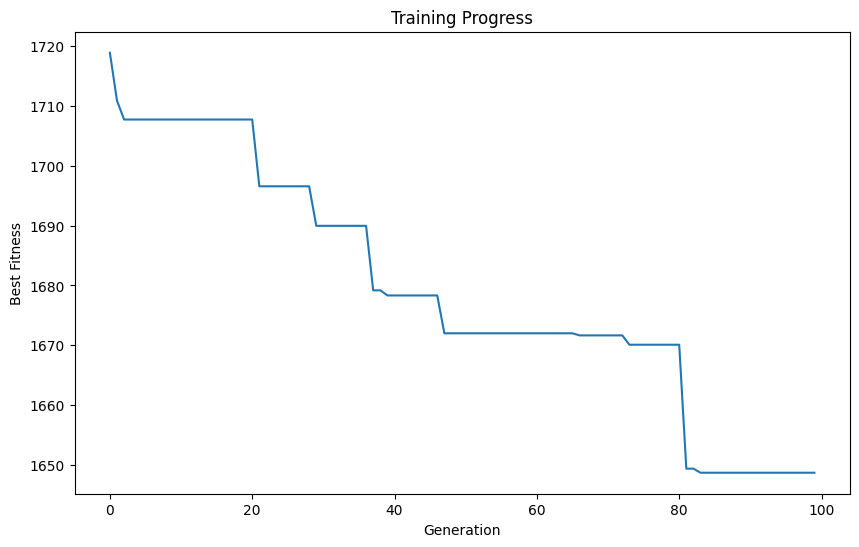

Best placement:
Rectangle 1: (x=2, y=20, w=18, h=20)
Rectangle 2: (x=60, y=0, w=18, h=19)
Rectangle 3: (x=25, y=2, w=15, h=18)
Rectangle 4: (x=17, y=3, w=6, h=7)
Rectangle 5: (x=46, y=0, w=13, h=10)
Rectangle 6: (x=68, y=20, w=10, h=19)
Rectangle 7: (x=59, y=22, w=8, h=11)
Rectangle 8: (x=23, y=21, w=17, h=11)


In [9]:
# Run the genetic algorithm
best_placement = genetic_algorithm(population_size=50, generations=100)

# Print the best placement
print("Best placement:")
for i, (x, y, w, h) in enumerate(best_placement):
    print(f"Rectangle {i + 1}: (x={x}, y={y}, w={w}, h={h})")

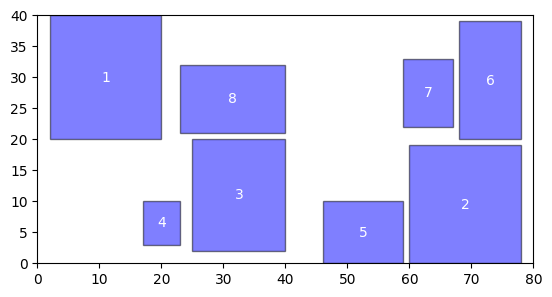

In [10]:
# Plot the result
fig, ax = plt.subplots()
ax.set_xlim(0, BIN_WIDTH)
ax.set_ylim(0, BIN_HEIGHT)

for i, (x, y, w, h) in enumerate(best_placement):
    ax.add_patch(Rectangle((x, y), w, h, edgecolor='black', facecolor='blue', alpha=0.5))
    ax.text(x + w / 2, y + h / 2, str(i + 1), color='white', ha='center', va='center')

plt.gca().set_aspect('equal', adjustable='box')
plt.show()